# Metrics

- skip_exec: true


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    auc,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder


## Prepare Example Model


In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="pandas")


In [ ]:
y = y.astype(int)


In [ ]:
categorical_columns = ["pclass", "sex", "embarked"]
numerical_columns = ["age", "sibsp", "parch", "fare"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [ ]:
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
test_preds = rf.predict_proba(X_test)[:, 1]

## Accuracy


In [ ]:
accuracy_score(y_test, test_preds > 0.1)


0.6067073170731707

In [ ]:
accuracy_score(y_test, test_preds > 0.5)


0.7865853658536586

In [ ]:
accuracy_score(y_test, test_preds > 0.9)


0.7530487804878049

## Recall


In [ ]:
recall_score(y_test, test_preds > 0.1)


0.928

In [ ]:
recall_score(y_test, test_preds > 0.5)


0.72

In [ ]:
recall_score(y_test, test_preds > 0.9)


0.376

## Precision


In [ ]:
precision_score(y_test, test_preds > 0.1)


0.4915254237288136

In [ ]:
precision_score(y_test, test_preds > 0.5)


0.72

In [ ]:
precision_score(y_test, test_preds > 0.9)


0.94

## F1 Score


In [ ]:
f1_score(y_test, test_preds > 0.5, average="binary")


0.72

In [ ]:
f1_score(y_test, test_preds > 0.5, average="micro")


0.7865853658536586

In [ ]:
f1_score(y_test, test_preds > 0.5, average="macro")


0.7737931034482759

In [ ]:
f1_score(y_test, test_preds > 0.5, average="weighted")


0.7865853658536586

## Confusion Matrix


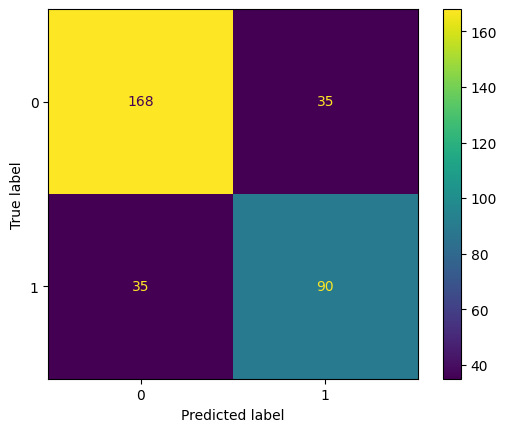

In [ ]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
cm = confusion_matrix(y_test, (test_preds > 0.5).astype(int))
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(ax=ax)
plt.show()


## ROC Curve


The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise.’ In other words, it shows the performance of a classification model at all classification thresholds. The Area Under the Curve (AUC) is the measure of the ability of a binary classifier to distinguish between classes and is used as a summary of the ROC curve.


When 0.5 < AUC < 1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative ones. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.


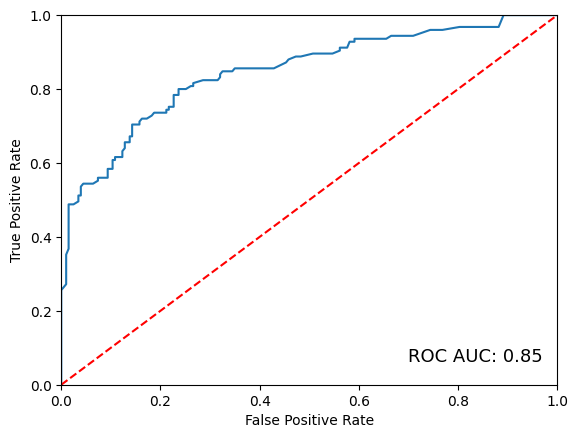

In [ ]:
fig, ax = plt.subplots()
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

fpr, tpr, _ = roc_curve(y_test, test_preds)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)

roc_auc_score = roc_auc_score(y_test, test_preds)

ax.plot([0, 1], [0, 1], "r--")
ax.annotate(f"ROC AUC: {roc_auc_score:.2f}", xy=(0.7, 0.1), va="top", xycoords="axes fraction", fontsize=13)
ax.set_xmargin(0), ax.set_ymargin(0)

plt.show()


Can the ROC AUC of a total test set be larger than the AUC for any subset of some test set partition?

Yes. [See here](https://stats.stackexchange.com/questions/416901/can-the-roc-auc-of-a-total-test-set-be-larger-than-the-auc-for-any-subset-of-som)


## Gini


The Gini Coefficient is the summary statistic of the Cumulative Accuracy Profile (CAP) chart. It is calculated as the quotient of the area which the CAP curve and diagonal enclose and the corresponding area in an ideal rating procedure.


In [ ]:
random_model_coords = [0, len(y_test)], [0, np.sum(y_test)]
rf_model_coords = (
    np.arange(0, len(y_test) + 1),
    np.append([0], np.cumsum([y for _, y in sorted(zip(test_preds, y_test), reverse=True)])),
)
perfect_model_coords = ([0, np.sum(y_test), len(y_test)], [0, np.sum(y_test), np.sum(y_test)])

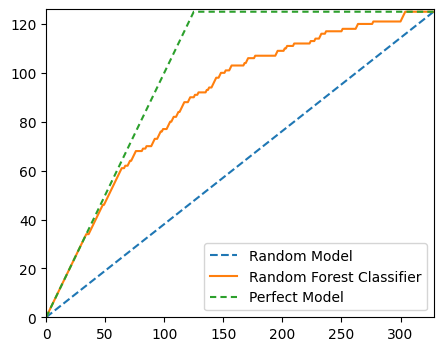

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.plot(*random_model_coords, linestyle="--", label="Random Model")
ax.plot(*rf_model_coords, linestyle="-", label="Random Forest Classifier")
ax.plot(*perfect_model_coords, linestyle=(0, (3, 2)), label="Perfect Model")
ax.set_xlim(0, len(y_test))
ax.set_ylim(0, np.sum(y_test) + 1)
plt.legend()
plt.show()

In [ ]:
# Area under Random Model
aR = auc(*random_model_coords)
# Area under Random Forest Model
a = auc(*rf_model_coords)
# Area under Perfect Model
aP = auc(*perfect_model_coords)

aR, a, aP


(20500.0, 29343.5, 33187.5)

In [ ]:
# Area between Perfect and Random Model
aP - aR


12687.5

In [ ]:
# Area between Random Forest and Random Model
a - aR


8843.5

In [ ]:
# Accuracy rate
accuracy_rate = (a - aR) / (aP - aR)
accuracy_rate

0.6970246305418719

The direct conversion between Gini and AUROC is given by:

$$Gini = 2 * AUC\_ROC - 1$$


In [ ]:
2 * roc_auc_score - 1


0.6938719211822659

Slightly different results because the auc is calculated using the trapezium method which is only an approximation of the true area under the curve.
